# Part 1: Similarity and Distance 

This section covers the concepts of similarity and distance using scipy and k-nearest neighbors. First, we import our packages with an alias (`import library as alias`) and load a couple helper functions I wrote to speed things up. These modules (collections of functions) are located in the `code` directory.

In [23]:
# packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.spatial.distance as ssd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

# helper modules
exec(open('helper_functions.py').read())

## Introduction

Distance and pattern recognition surfaces over and over in data science workflows. It's relatively simple but incredibly useful for both data science and engineering workflows. It's also underutilized. Take a reservoir engineering example. You have a field of wells that are producing oil. You've just installed a new well in the area and want to predict its production profile. Since this well is in a well developed area, there are lots of wells in close proximity, but the geology is complex. You start by taking its closest neighbor using the northing and easting. Unfortunately, you discover that the well is much shallower and in different geology than that well. So, you pull a couple wells that are closer to the same depth and in similar rock. When looking into these, you discover that all these wells are pretty old and that they were completed using different technology. This prompts you to search further and find newer wells with similar geology. After you've spent a couple hours picking similar wells you feel satisfied and average their profiles to produce an average curve.

You've just executed a k-Nearest Neighbors (kNN) regression manually, slowly, and without any statistical underpinning. Effectively, you ran through an ad-hoc way of measuring an abstracted distance between features of your well (distance, time, geology, etc.) to select the most appropriate examples for generating a type curve. But this process can be automated, evaluated for performance metrics, and optimized for statistical performance. Oh and did I mention that it's fast and repeatable?

The kNN algorithm is one example of a distance based data-science techniques. I hesitate to call it machine learning, because distance based techniques don't really 'learn' by training a model through fitting and hyperparameter tuning. Yet, this technique is incredibly robust and effective. There are also similar algorithms for unsupervised learning (i.e. clustering). In general, there are three steps to implementing a distance based technique successfully, all of which were considered in the ad-hoc process above.

1. Choose a good distance metric with appropriate features
2. Rank potential candidates based on their distance to your target
3. Use a select number of these candidates to perform regression, classification, or clustering

## Distance Metrics

So how do we measure distance? It's important to first understand that a) there are a lot of different ways to measure distance and b) that each method is a mathematical construct for a specific understanding of distance, and each has pros and cons. For example, Manhattan, or taxi cab, distance can be very useful when working with rasters or trying to evaluate connectivity of points. Euclidean distance is simple and provides the straight line distance between two points, which is why it is used exclusively in a lot of algorithms. There are even distance metrics for categorical and [binary data](https://en.wikipedia.org/wiki/Jaccard_index). The point of selecting a metric is to define our understanding of what constitutes 'near' and 'far' in multidimensional space. Don't underestimate the importance of this - the performance of any regression, classification, or clustering algorithm will ultimately depend on how you define your distance metric.

This chunk of code loads our well data, which I obtained from the [BCOGC](https://www.bcogc.ca/online-services) and preprocessed. We use pandas to load the csv, clean the date columns, and show the first couple rows of the dataframe (the head).

In [3]:
# read in completion data
well_data = pd.read_csv('../data/bcogc_well_comp_info.csv')

# encode dates properly
date_cols = ['frac_start_date','frac_end_date', 'on_prod_date']

# a couple nice examples of method chaining in python to clean up date columns
well_data.loc[:,date_cols] = (
        well_data
        .loc[:,date_cols]
        .apply(pd.to_datetime, errors='coerce')
        .apply(pd.to_numeric, errors='coerce')
        .div(31556952) # second in a year
        )

well_data.head()

,unique_surv_id,wa_num,drilling_event,ground_elevtn,mean_ss_tvd,mean_ss_easting,mean_ss_northing,survey_well_type,on_prod_date,last_reported_date,...,horiz_wells_in_5km,horiz_wells_in_10km,horiz_wells_in_25km,first_order_residual,isotherm,paleozoic_structure,raw_montney_top,third_order_residual,seismogenic,n_quakes
0,26709-0,26709,0,967.0,-1038.286881,541258.8972,6312071.186,horizontal,4.649787e+10,9/1/2019,...,11,11,11,-36.180738,85.046572,-1248.991716,2018.972300,57.171039,True,4
1,26851-0,26851,0,1023.8,-1066.814758,545866.1632,6316437.733,horizontal,4.374902e+10,9/1/2019,...,3,3,3,-60.378993,78.536477,-1176.143361,1891.195420,38.373928,True,2
2,27232-0,27232,0,1026.5,-1041.326136,546102.0775,6313238.866,horizontal,4.400090e+10,9/1/2019,...,5,5,5,-56.814330,84.212037,-1198.455581,1904.202898,35.885353,True,1
3,27296-0,27296,0,989.6,-1009.757363,545620.7248,6308451.059,horizontal,4.349713e+10,9/1/2019,...,1,1,1,-6.258352,89.416457,-1280.473172,1999.194236,78.190771,False,0
4,27302-0,27302,0,1045.0,-1118.887041,542922.7749,6315105.076,horizontal,4.374902e+10,5/1/2019,...,6,6,6,-37.993603,90.301766,-1220.128996,2160.073261,60.405326,False,0


Most machine learning algorithms can only use numeric data. So a lot of data science preprocessing involves picking numeric features, which is what the code below is doing.

In [4]:
# select numeric data, replace NaN and Inf values with zero
num_well_data = (well_data
                 .select_dtypes(include = [np.number])
                 .replace([np.inf, -np.inf], np.nan)
                 .fillna(0)
                 .copy())

#choose columns
select_col = ['mean_ss_tvd', 'mean_ss_easting', 'mean_ss_northing', 
             'on_prod_date', 'frac_start_date','calc_completed_length_m', 
             'mean_proppant_per_stage_t', 'calc_total_proppant_t',
             'total_gas_injected_m3', 'mean_fluid_per_stage_m3',
             'calc_total_fluid_m3', 'avg_stage_length', 'avg_stage_spacing',
             'mean_rate_m3_min', 'mean_stage_duration_min', 'mean_breakdown_mpa', 
             'mean_isip_mpa', 'fluid_intensity_comp_length_m3_m',
             'proppant_intensity_comp_length_t_m', 'frac_duration_days', 
             'breakdown_isip_ratio', 'min_midpoint_dist', 'horiz_wells_in_10km', 
             'first_order_residual', 'isotherm', 'paleozoic_structure', 
             'raw_montney_top', 'third_order_residual', 'n_quakes']

# make a select dataframe
select_well_data = num_well_data[num_well_data
                                 .columns
                                 .intersection(select_col)]

# We will write this as a .csv file so we can use it in later notebooks
select_well_data.to_csv('../data/unscaled_well_data.csv',index=False)

We select the geospatial columns and pick a well in the centre of the map as a `target`. We then assign a distance column with the distance between the target and the other wells.

In [7]:
# pick the closest well to the centre of our area as the target using euclidean distance
coord_cols = ['mean_ss_tvd', 'mean_ss_easting', 'mean_ss_northing']
centroid = select_well_data.loc[:,coord_cols].mean()

target_index = (select_well_data
                .loc[:,coord_cols]
                .apply(ssd.euclidean, axis=1, v=centroid)
                .idxmin())

# assign the distance function 
dist_func = ssd.euclidean

# assign the distance between the target and all the other wells using dist_func
select_well_data = select_well_data.assign(distance = select_well_data.apply(
        dist_func, axis=1, v=select_well_data.loc[target_index,:]))

We can use this distance to predict a value. Boom. You've just done kNN regression and can happily call yourself a champion of data science in the mirror. We use a helper function to plot these wells on a map along with the target. We also report the predicted and actual values using this method. 

Unscaled kNN prediction: 1.44 vs target: 1.54


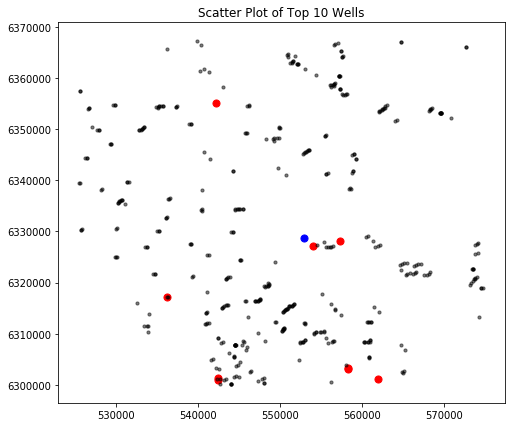

In [19]:
# distance on unscaled data
top_k_index = select_well_data.nsmallest(10,'distance').index
plot_top_n(select_well_data, top_k_index, target_index) #, 'Unscaled Euclidean')

# let's 'predict' the breakdown_isip_ratio - kinda a fluke
pred = select_well_data.loc[top_k_index,'breakdown_isip_ratio'].mean()
actual = select_well_data.loc[target_index,'breakdown_isip_ratio']

# print using f-strings
print('Unscaled kNN prediction: ' + f'{pred:.3}' + ' vs target: ' + f'{actual:.3}')

But distance, similarity, and clustering in general are very sensitive to scale. In the above dataframe you can see that the date column, coordinates, and geology parameters have very different scales. In this chunk we use the `sklearn` preprocessing framework (StandardScaler) to scale the dataframe. We write this for future use and then use it to run a knn prediction similar to the above.

Scaled Euclidean kNN prediction: -0.17 vs target: -0.122


/home/chuao/.conda/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


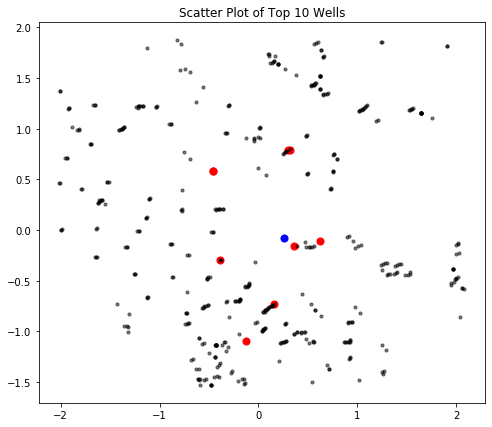

In [25]:
# let's scale the data using sklearn and try it again
scaled_well_data = pd.DataFrame(
        StandardScaler()
        .fit_transform(select_well_data), 
        columns=select_well_data.columns)

# We will write this as a .csv file so we can use it in later notebooks
scaled_well_data.to_csv('../data/scaled_well_data.csv', index=False)

# fortunately we are using functions - works exactly the same as above
predict_print_knn(well_data_df = scaled_well_data, 
                  dist_func = ssd.euclidean,
                  k = 10, 
                  target_index = target_index, 
                  target_column = 'breakdown_isip_ratio',
                  title_str = 'Scaled Euclidean')

A finally, we do the exact same thing, but using the official sklearn framework

In [42]:
# Use the sklearn methods
X = scaled_well_data.drop('breakdown_isip_ratio', axis=1)
y = scaled_well_data['breakdown_isip_ratio']
sk_knn = KNeighborsRegressor(n_neighbors=10).fit(X,y)
pred = sk_knn.predict(scaled_well_data
               .iloc[[target_index]]
               .drop('breakdown_isip_ratio',axis=1))
pred = pred.item()
actual = scaled_well_data.loc[target_index,'breakdown_isip_ratio']
print(f'sklearn kNN prediction: {pred:5.3f} vs target: {actual:5.3f}')

sklearn kNN prediction: -0.170 vs target: -0.122


The last thing we should talk about is the distance measurement. You can realize very different results based on the type of distance function you use. We use `cosine` and `canberra` distnace.

/home/chuao/.conda/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Scaled Cosine kNN prediction: -0.0786 vs target: -0.122
Scaled Mahalanobis kNN prediction: -0.0619 vs target: -0.122


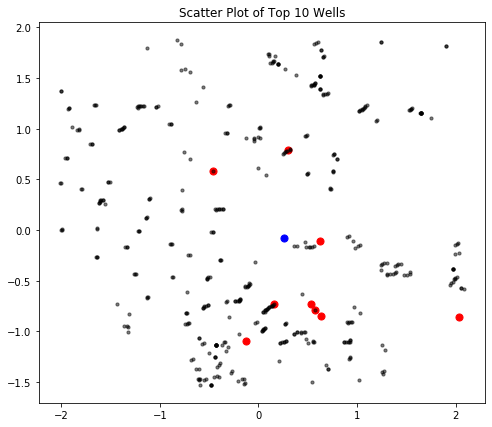

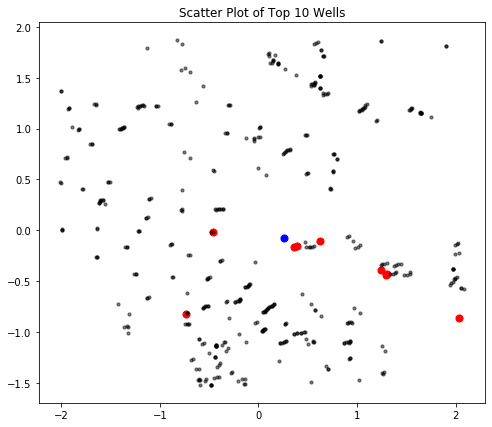

In [45]:
# try a couple new distance function
predict_print_knn(well_data_df = scaled_well_data, dist_func = ssd.cosine,
                  k = 10, target_index = target_index, 
                  target_column = 'breakdown_isip_ratio', 
                  title_str = 'Scaled Cosine')

predict_print_knn(well_data_df = scaled_well_data, dist_func = ssd.canberra,
                  k = 10, target_index = target_index, 
                  target_column = 'breakdown_isip_ratio', 
                  title_str = 'Scaled Mahalanobis')

## Acknowledgments

This presentation wouldn't have been possible without all the support I've received from the following organizations
<img src="../images/untapped_sponsors.jpg" alt="My amazing sponsors" style="width: 400px;"  align="left"/>
